<h1 style="font-size: 3em; text-align: center">Graphs for Trends Reports </h1>


### This notebook explores the different types of graphs we should include in our reports web app.

## Define Metrics & Periods & Bins

### Indicators

`indicators = ["nr_of_sales", "sales_volume", "median_sales_price", "average_sales_price"]`

### Locations
`locations = ["by_parish", "by_region", "all"]`

`by_region` Corresponds to `West`, `Central`, `East`

`by_parish` Corresponds to `['Pembroke', 'Warwick', 'Paget', 'Hamilton', 'Southampton', 'Smiths', 'Sandys', "St. George's", 'Devonshire']`

### Type

`property_type = ["house", "condo", "apartment", "commercial", "land", "fractional", "all"]`


### Time Bins

- **yearly**: show data in `2018, 2019, 2020, 2021, 2022 ...` (being able to select range of years)

- **quarterly**: show data in `2021Q1, 2021Q2, 2021Q3, 2021Q4, 2022Q1, 2022Q2, ... ` (selecting range of years)

- **year_to_date**: show metric in interval `"Jan 1st" -> "Today"`

- **year_over_year**: `(current_year - previous_year)/previous_year`
  for example:
         (Sales20 - Sales21)/Sales21 | (Sales21 - Sales22)/Sales22
 
- **quarter_to_quarter**: `(current_quarter_22 - previous_quarter_22)/previous_quarter_22`
  for example: 
        (Q2-Q1)/Q1 | (Q3-Q2)/Q2 | (Q4-Q3)/Q3
  
  
- **quarter_over_quarter**: `(Qi_year/Qi_previous_year)` (selecting the range of years) 
  for example: 
        (Q1-21/Q1-20) | Q2-21/Q2-20) | (Q3-21/Q3-20) | Q4-21/Q4-20)
         
**Cutomer:** 
> year to date (January of current year to current month. Ideally we could compare to the same period the previous year)** 

**Al:**
> => the way I'm writing the program it goes up to the latest date from LTRO in 2022.
(in our case we have  LTRO data until July 2022.  So I compare sales from the intervals:
`[January 2021 - July 2021]` and `[January 2022 - July 2022].` When LTRO gets their system in shape and we can get fresh data, we can still compare the most recent sale to the sales the year prior at that date.

**Customer:**
>  **number of active listings Q to Q, Q over Q:**  

**Al:**
> We don't have the data to calculate this.  For this, I would need to send queries like this to PropertySkipper:  
- On average, How many active listings did you have in Q1 2021
- On average, How many active listings did you have in Q1 2022.

> However we don't have access to that information.  Over time, we could store this historical information, but it will take a year before we can show a Q over Q, and at least 6 months before showing that Q to Q statistic.
 
 
### Market Segments

```
house_price_brackets = {"starter": [0,0.75], "mid-market": [0.75, 1.5], 
                                "high-market": [1.5,2.5], "luxury": [2.5, 5], "top-luxury": [5]}
house_arv_brackets = {"starter": [0, 0.0335], "mid-market": [0.0335, 0.063], 
                              "high-market": [0.063, 0.126], "luxury": [0.126]}

condo_price_brackets = {"starter": [0, 0.75], "mid-market": [0.75, 1.3], 
                        "high-market": [1.3, 2], "luxury": [2]}
condo_arv_brackets =  {"starter": [0, 0.0396], "mid-market": [0.0396, 0.0581], 
                       "high-market": [0.0581, 0.0746], "luxury": [0.0746]}
```


**Customer:** 
> We need to find average prices broken down by the ARV bands we worked out. We need to understand what is happening in those markets on a quarterly and yearly basis

### Inventory Runway

How many months of sales would the current inventory enable?

`(# of properties currently for sale) / (# of properties sold per month*)`

*To find the properties sold per month, we could take an average over the last 6 - 12 months where we have data available.

### Trends in ARV brackets

If we fix ARV ranges (the constant), how do sales vary over time in those brackets?
(For example, is the median sales price in the mid-market growing?)

# Overview of filtering Criteria

- Note that some filters need to be applied before others, so we don't aggregate too early (aggregating data we mean to exclude later)

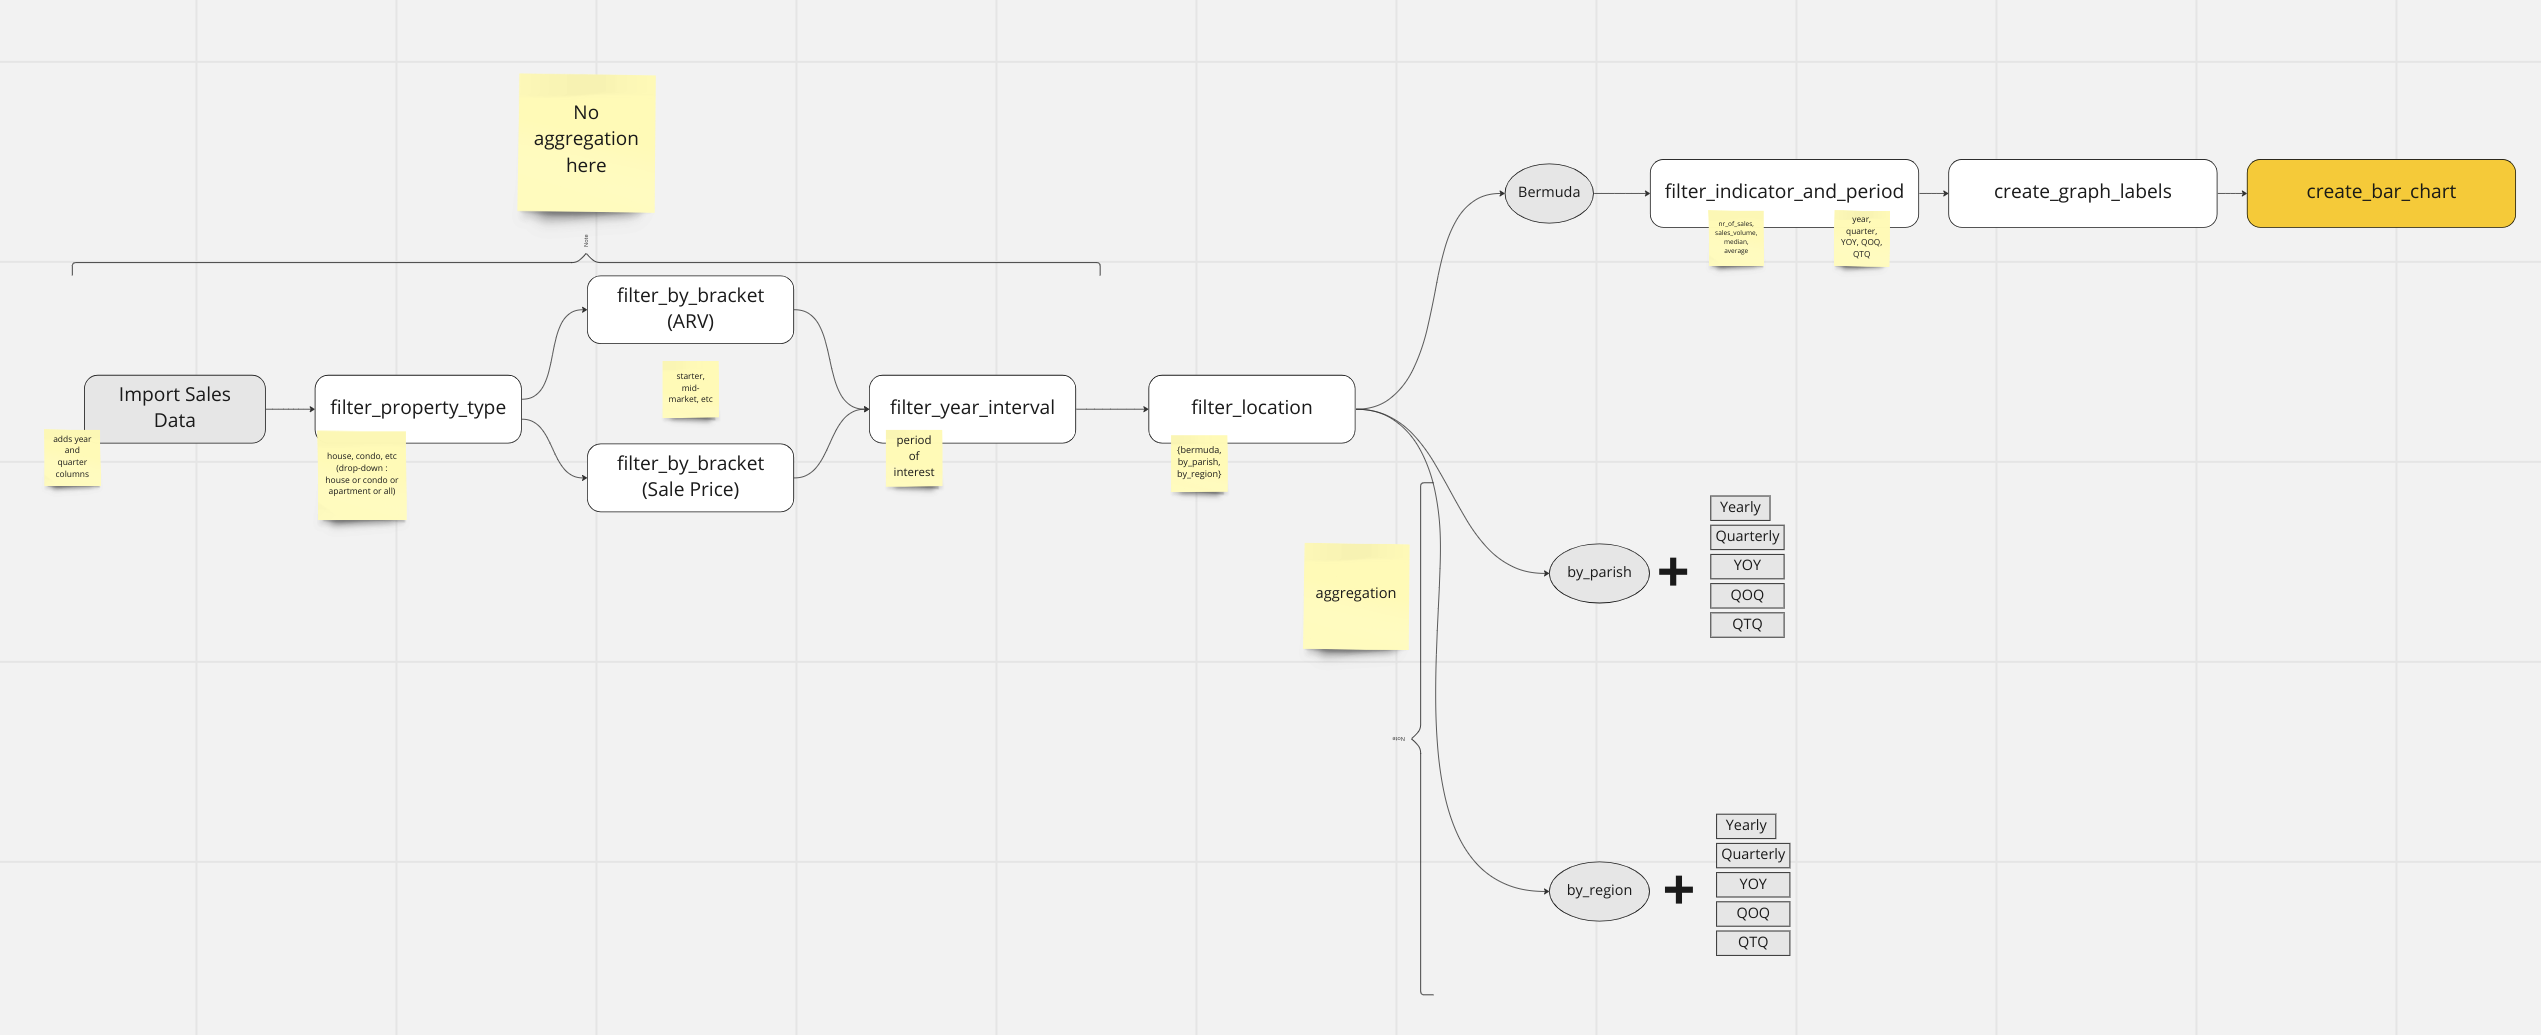

In [6]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import reportutils as rep

In [7]:
indicators = ["nr_of_sales", "sales_volume", "median_sales_price", "average_sales_price"]

periods = ["year", "year_to_date", "year_over_year", 
           "quarter", "quarter_over_quarter", "quarter_to_quarter" ]

locations = ["by_parish", "by_region", "Bermuda"]
# possible parishes are:
# ['Pembroke', 'Warwick', 'Paget', 'Hamilton', 'Southampton', 'Smiths', 'Sandys', "St. George's", 'Devonshire']
# possible regions are: ['western', 'central', 'eastern']


property_types = ["house", "condo", "apartment", "commercial", "land", "fractional", "all"]

house_price_brackets = {"starter": [0,0.75], "mid-market": [0.75, 1.5], 
                                "high-end": [1.5,2.5], "luxury": [2.5, 5], "top-luxury": [5]}
house_arv_brackets = {"starter": [0, 0.0335], "mid-market": [0.0335, 0.063], 
                              "high-end": [0.063, 0.126], "luxury": [0.126]}

condo_price_brackets = {"starter": [0, 0.75], "mid-market": [0.75, 1.3], 
                        "high-end": [1.3, 2], "luxury": [2]}
condo_arv_brackets =  {"starter": [0, 0.0396], "mid-market": [0.0396, 0.0581], 
                       "high-end": [0.0581, 0.0746], "luxury": [0.0746]}

## How many different graphs can we create?

In [8]:
# assumptions about which filtering criteria are compatible may reduce the number
len(indicators)*len(periods)*len(locations)*(len(property_types)-2)*len(house_price_brackets)

1800

### Utility Functions

see file `reportutils.py` for functions created for:

- filtering data
- Plotting filtered data

(functions are called below as `rep.*`)

# Filter and Graph Functions

The following function can be used for functions with:
    
    - yearly or quarterly periods
    - location=all (no filtering by parish or region)

In [9]:
def filter_and_graph(df, starting_year, final_year, property_type, 
                     bracket_dict, bracket, indicator, period, location):
    df = rep.filter_year_interval(df, starting_year, final_year)
    # filter property type selected
    df = rep.filter_property_type(df, property_type) 
    # filter by market segment
    df = rep.filter_by_bracket(df, bracket_dict, bracket) 
    # filter and aggregate with indicator
    last_sale, df = rep.filter_indicator_and_period(df, indicator, period) 
    # generate label
    my_title, my_ylabel = rep.create_graph_labels(indicator, period, location, property_type, bracket) 
    # plot with disclaimer
    rep.create_bar_chart(df, last_sale, my_title, my_ylabel, period) 
    return df

## Import Sales Data

Import and prepare data to display quarters and years when needed

In [10]:
df = rep.import_sales_data("./../kw-data-import/data/kw-sales.csv")

## Apply Filters

### Example 0: Total Yearly Sales Volume in Bermuda

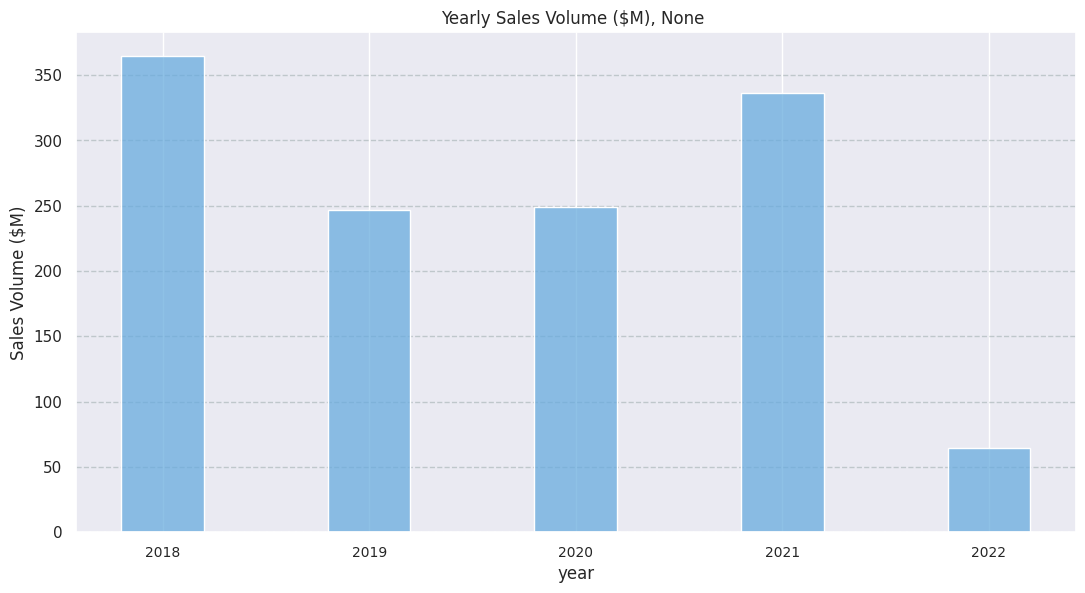

year
2018    364.644223
2019    247.015630
2020    248.793307
2021    336.357326
2022     64.662250
Name: price, dtype: float64


In [19]:
indicator = "sales_volume"
period = "year"
starting_year, final_year = 2018, 2022
location = "Bermuda"
property_type = "all"
bracket_dict = None # house_arv_brackets
bracket = None 

df = rep.import_sales_data("./../kw-data-import/data/kw-sales.csv") # import data
df = filter_and_graph(df, starting_year, final_year, property_type, 
                     bracket_dict, bracket, indicator, period, location)
print(df)

### Example 0.a: Total # of Salesin Bermuda

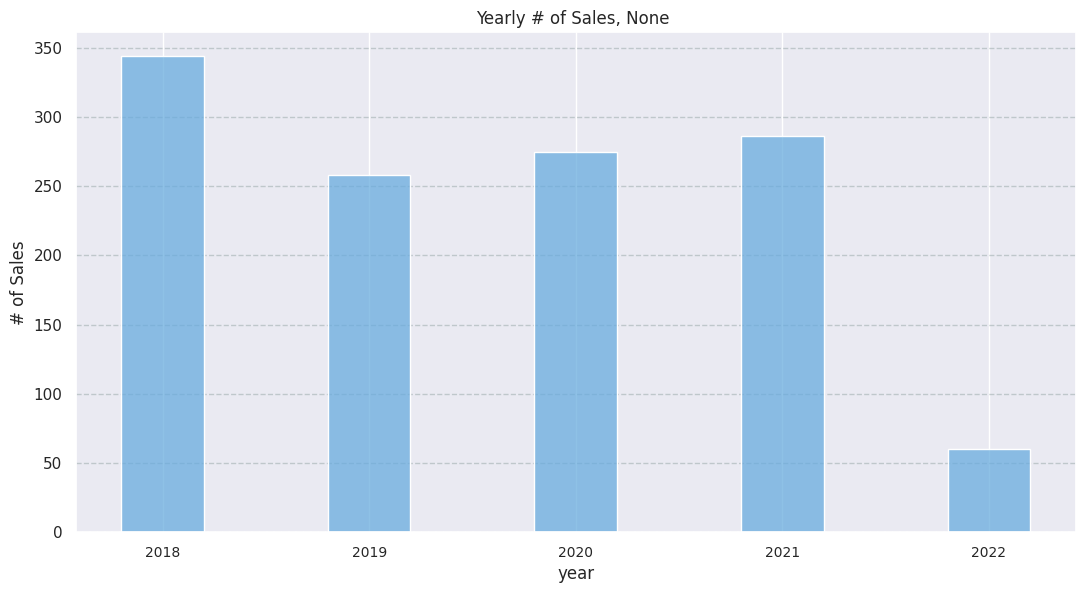

year
2018    344
2019    258
2020    275
2021    286
2022     60
Name: price, dtype: int64


In [20]:
indicator = "nr_of_sales"
period = "year"
starting_year, final_year = 2018, 2022
location = "Bermuda"
property_type = "all"
bracket_dict = house_arv_brackets
bracket = None 

df = rep.import_sales_data("./../kw-data-import/data/kw-sales.csv") # import data
df = filter_and_graph(df, starting_year, final_year, property_type, 
                     bracket_dict, bracket, indicator, period, location)
print(df)

### Example 1: # of Yearly sales of high-end Houses

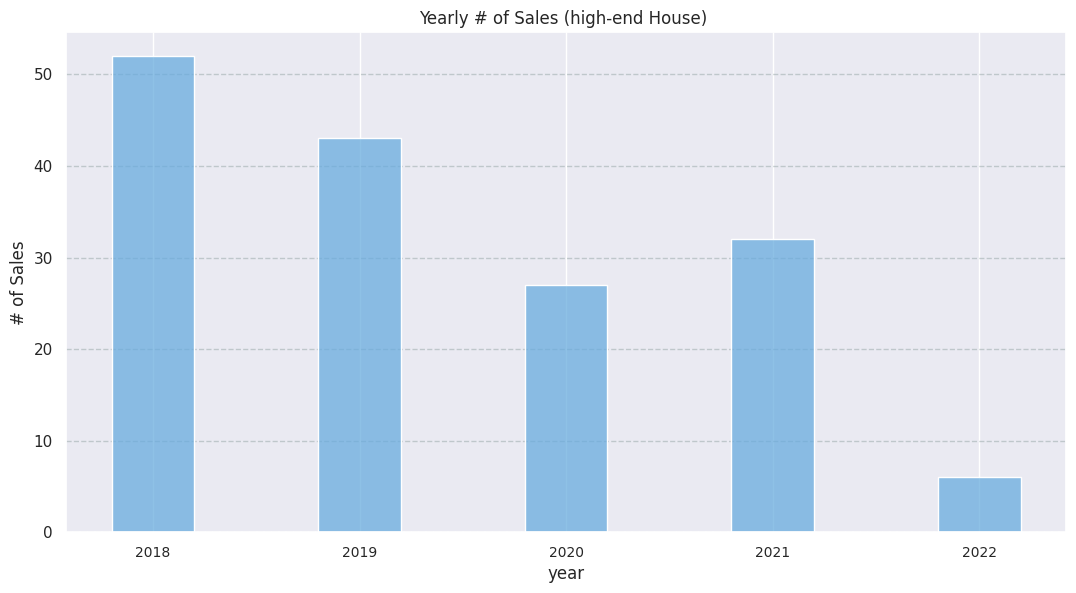

In [15]:
indicator = "nr_of_sales"
period = "year"
starting_year, final_year = 2018, 2022
location = "Bermuda"
property_type = "house"
bracket_dict = house_arv_brackets
bracket = "high-end" 

df = rep.import_sales_data("./../kw-data-import/data/kw-sales.csv") # import data
df = filter_and_graph(df, starting_year, final_year, property_type, 
                     bracket_dict, bracket, indicator, period, location)

### Example 2: # of quarterly sales of high-end Houses

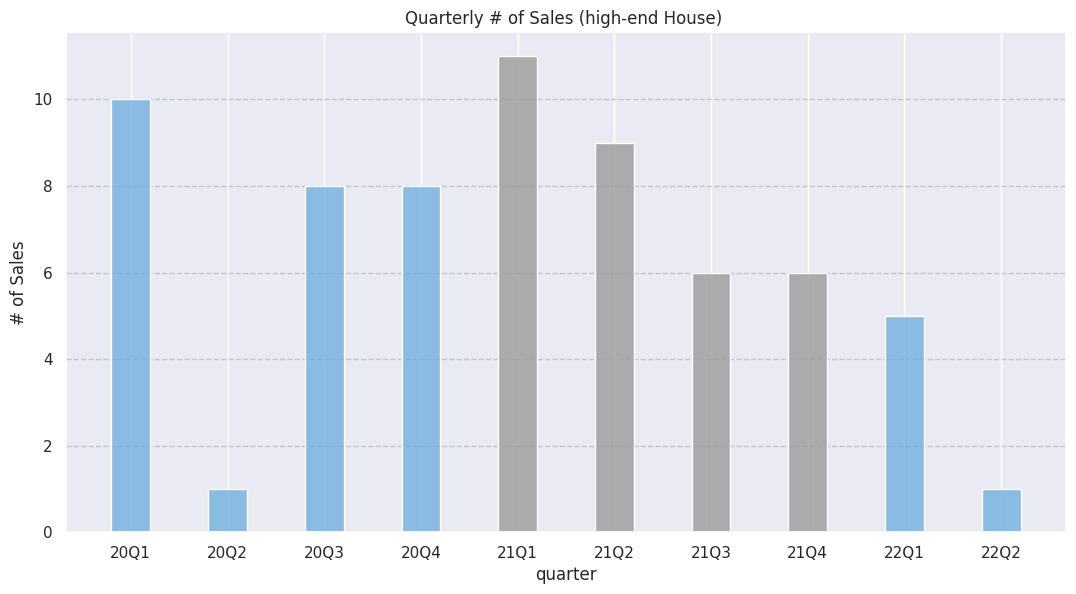

In [60]:
indicator = "nr_of_sales"
period = "quarter"
starting_year, final_year = 2020, 2023
location = "Bermuda"
property_type = "house"
bracket_dict = house_arv_brackets
bracket = "high-end" 

df = rep.import_sales_data("./../kw-data-import/data/kw-sales.csv") # import data
df = filter_and_graph(df, starting_year, final_year, property_type, 
                     bracket_dict, bracket, indicator, period, location)

### Create alternating colours that change every quarter (multiple of 4)

In [61]:
my_blue = (0.41, 0.674, 0.87, 0.75)
my_gray = (0.61, 0.61, 0.61, 0.8)
my_colours = []
# nr_blocks_of_four = df.shape[0]/4
for x in range(df.shape[0]):
    if x%8 < 4:  # 
        my_colours.append(my_blue)
    else:
        my_colours.append(my_gray)

### Example 3: # of Year-over-Year sales volume in starter condos (all of Bermuda)

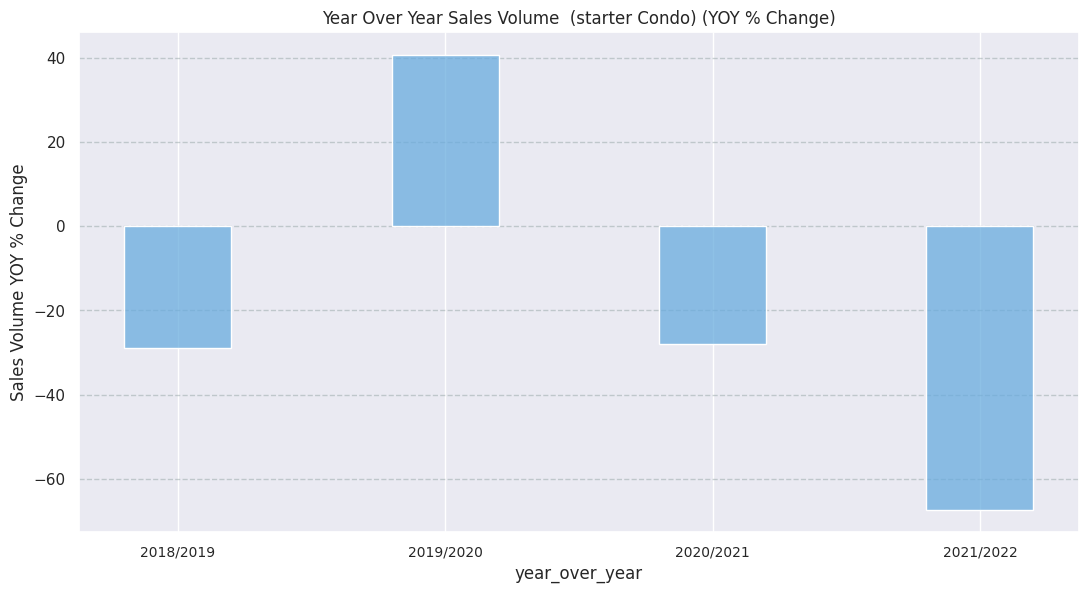

In [62]:
indicator = "sales_volume"

starting_year, final_year = 2018, 2022
period = "year_over_year"
location = "Bermuda"
property_type = "condo"
bracket_dict = condo_arv_brackets
bracket = "starter"

df = rep.import_sales_data("./../kw-data-import/data/kw-sales.csv") # import data
df = filter_and_graph(df, starting_year, final_year, property_type, 
                     bracket_dict, bracket, indicator, period, location)


### Example 4: Average sales prices for luxury condos, yearly in Bermuda

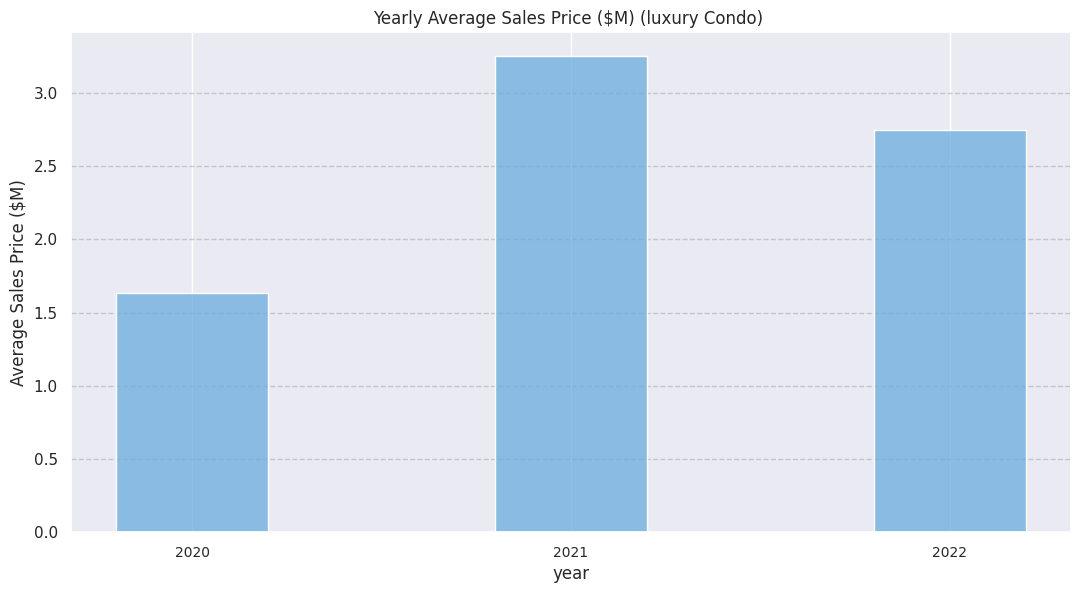

In [64]:
indicator = "average_sales_price"
starting_year, final_year = 2020, 2022
period = "year"
location = "Bermuda"
property_type = "condo"
bracket_dict = condo_arv_brackets
bracket = "luxury"

df = rep.import_sales_data("./../kw-data-import/data/kw-sales.csv") # import data
df = filter_and_graph(df, starting_year, final_year, property_type, 
                     bracket_dict, bracket, indicator, period, location)

### Example 5: Average sales prices for luxury condos, yearly in Bermuda

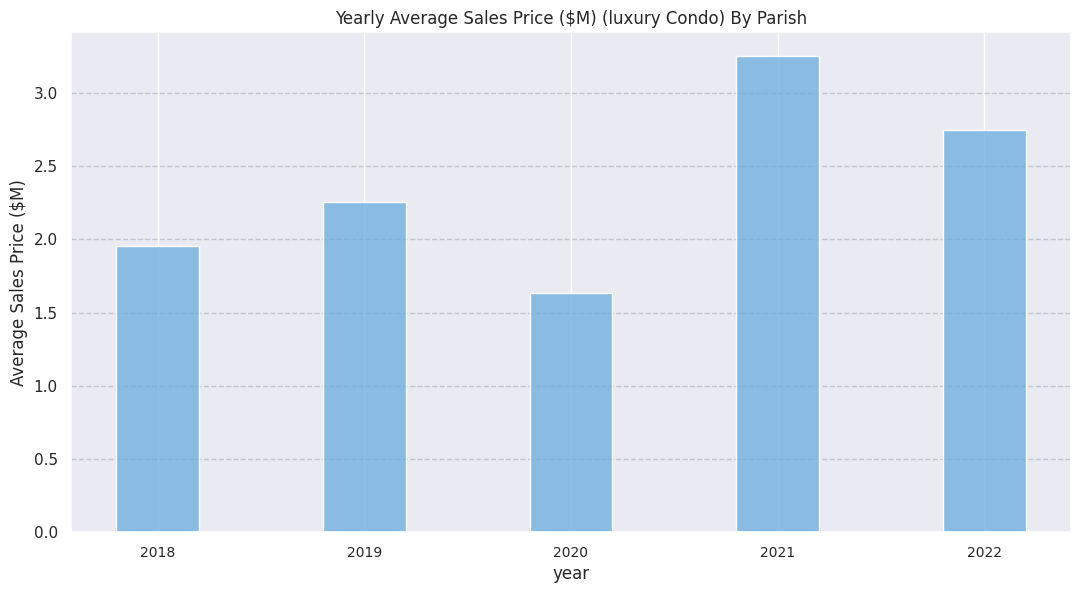

In [71]:
indicator = "average_sales_price"
starting_year, final_year = 2018, 2022
period = "year"
location = "by_parish"
property_type = "condo"
bracket_dict = condo_arv_brackets
bracket = "luxury"

df = rep.import_sales_data("./../kw-data-import/data/kw-sales.csv") # import data
df = filter_and_graph(df, starting_year, final_year, property_type, 
                     bracket_dict, bracket, indicator, period, location)


# YTY Calculation

In [25]:
yty["by_year"] = df.copy()
yty["shifted"] = df.shift(periods=1, axis="rows")
yty["by_year"]/yty["shifted"]*100

NameError: name 'yty' is not defined

In [19]:
yyy = [58994750, 329322326, 245519307, 242763630, 364234223]
# YTY_ratios: current_year/previous_year
YTY_ratios = [58994750/329322326*100, 329322326/245519307*100,245519307/242763630*100, 242763630/364234223*100 ]

YTY_ratios

[17.913984368007895, 134.13296494845514, 101.135127613638, 66.65041741560897]

# YOY Calculation

In [192]:
# (current_year - previous_year)/previous_year
YOY_ratios = [(58994750-329322326)/329322326*100, (329322326-245519307)/245519307, 
              (245519307-242763630)/242763630, (242763630-364234223)/364234223]
YOY_ratios

[-82.0860156319921,
 0.3413296494845515,
 0.011351276136380066,
 -0.33349582584391035]

In [228]:
indicator = "sales_volume"
period = "year_to_year"
location = "Bermuda"
property_type = "all"
house_price_bracket = None

df = rep.import_sales_data("./kw-data-import/data/kw-sales.csv")
df = filter_property_type(df, property_type) # does not filter because property_type = all
df = filter_by_bracket(df, house_price_brackets, bracket=house_price_bracket) # does not filter, bracket=None

filtered_dataframe = df.groupby(["year"])["price"].agg(indicator_dict[indicator])
filtered_dataframe = filtered_dataframe.pct_change()*100

In [229]:
year_to_date = df["year"].max()

this_jan_string = f"{year_to_date}-01-01"
last_jan_string = f"{year_to_date-1}-01-01"

sales_this_year = df[df.index > this_jan_string]
last_sale_this_year = sales_this_year.index.max() 
last_sale_a_year_ago = f"{last_sale_this_year.year}-{last_sale_this_year.month}-{last_sale_this_year.day}"


sales_last_year = df[(df.index > last_jan_string) & (df.index < last_sale_a_year_ago)]

indicator_dict = {
        "nr_of_sales" : "count",
        "sales_volume": "sum",
        "median_sales_price": "median",
        "average_sales_price": "mean"
    }

indicator_to_today_last_year = sales_last_year.price.agg(indicator_dict["sales_volume"])
indicator_to_today = sales_this_year.price.agg(indicator_dict["sales_volume"])
indicator_to_today/indicator_to_today_last_year*100

15.226334719142065

### Example 2: Total Yearly sales volume for mid-market Condos

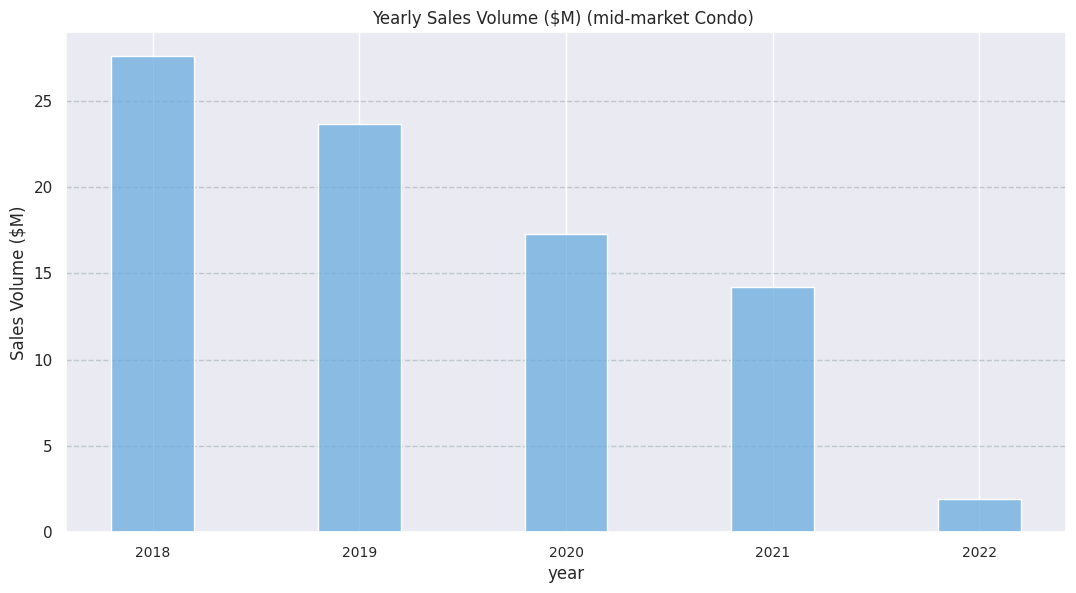

In [24]:
indicator = "sales_volume"
period = "year"
location = "Bermuda"
property_type = "condo"
bracket = "mid-market"

df = rep.import_sales_data("./../kw-data-import/data/kw-sales.csv") # import data
df = rep.filter_property_type(df, property_type) # filter property type selected
df = rep.filter_by_bracket(df, house_price_brackets, bracket) # filter by market segment
last_sale, df = rep.filter_indicator_and_period(df, indicator, period) # filter and aggregate with indicator
my_title, my_ylabel = rep.create_graph_labels(indicator, period, location, property_type, bracket) # generate label
rep.create_bar_chart(df, last_sale, my_title, my_ylabel, period) # plot with disclaimer

### Example 3: Average price of fractional Sales in Bermuda (Quarterly for 2020 - 2021)

In [24]:
indicators

['nr_of_sales', 'sales_volume', 'median_sales_price', 'average_sales_price']

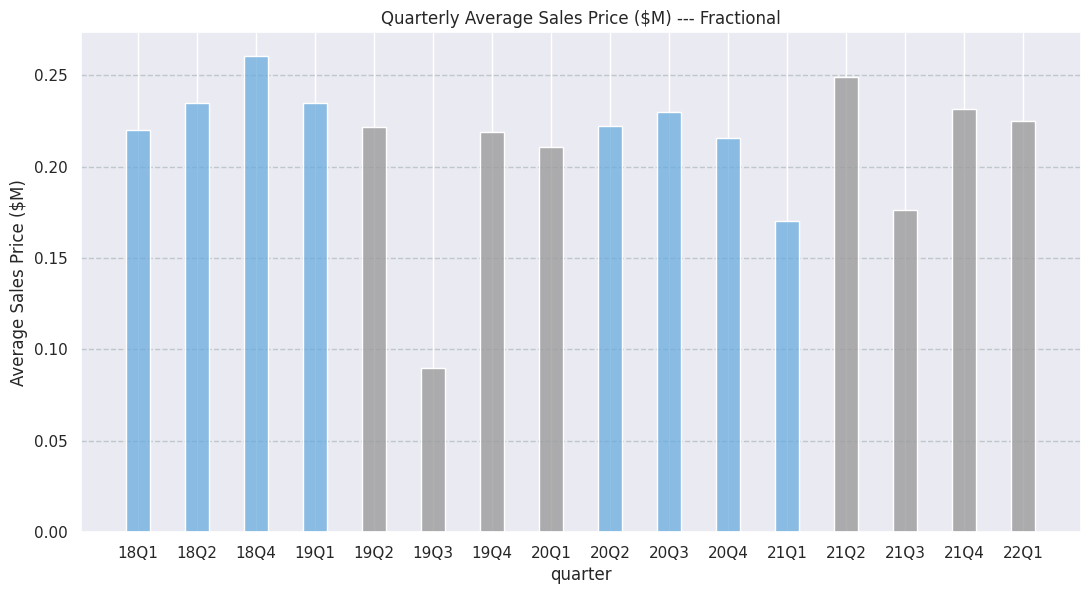

In [23]:
indicator = "average_sales_price"
# indicator = "nr_of_sales"
period = "quarter"
location = "Bermuda"
property_type = "fractional"
bracket = None # "mid-market"

df = rep.import_sales_data("./../kw-data-import/data/kw-sales.csv") # import data
df = rep.filter_property_type(df, property_type) # filter property type selected
df = rep.filter_by_bracket(df, house_price_brackets, bracket) # filter by market segment
last_sale, df = rep.filter_indicator_and_period(df, indicator, period) # filter and aggregate with indicator
my_title, my_ylabel = rep.create_graph_labels(indicator, period, location, property_type, bracket) # generate label
rep.create_bar_chart(df, last_sale, my_title, my_ylabel, period) # plot with disclaimer

# ☝️ Note this bars are not correct.
For `18Q3` data seems to be missing. So instead it should show a gap.  Because it doesn't the colour scheme is shifted and not correct (it should be one alternating colour for each year).

# Filtering by location

In [14]:
df = rep.import_sales_data("./../kw-data-import/data/kw-sales.csv") # import data
property_type = "house"
bracket = None
starting_year, final_year = 2019, 2022

period = "quarter"
location = "by_parish"
indicator = "average_sales_price"

df = rep.filter_property_type(df, property_type) # filter property type selected
df = rep.filter_by_bracket(df, house_price_brackets, bracket) # filter by market segment
df = rep.filter_year_interval(df, starting_year, final_year) # year interval

df = df.groupby(['parish', 'year'], as_index=False).agg({"price": "mean"})

# ['Pembroke', 'Warwick', 'Paget', 'Hamilton', 'Southampton', 'Smiths', 'Sandys', "St. George's", 'Devonshire']
# possible regions are: ['western', 'central', 'eastern']

### Step to Group by period & Parish

### Graphs for (`by_parish`, `yearly`) 


In [18]:
def bar_graph_by_parish_and_period(df, my_period):
    '''
    :param str: my_period can be "year" or "quarter"
    '''

    all_periods = df[my_period].sort_values().unique()
    all_parishes = df.parish.unique()

    parish_price_dict = {}
    for aparish in all_parishes:
        parish_aggregated_df = df[df.parish == aparish]
        prices_for_parish = parish_aggregated_df.price
        if len(prices_for_parish) < len(all_periods):
            # his parish have some missing quarters/years (or quarters/years with zero sales)?
            missing_periods = set(all_periods).difference(parish_aggregated_df[my_period])
            missing_periods_dict = {'parish': aparish, my_period: list(missing_periods), "price": 0}
            missing_periods_df = pd.DataFrame(missing_periods_dict)
            full_prices_for_parish = pd.concat([parish_aggregated_df, 
                                                missing_periods_df]).sort_values(by=[my_period]).reset_index()
            parish_price_dict[aparish] = full_prices_for_parish

        else:
            parish_price_dict[aparish] = parish_aggregated_df # .reset_index()




    x = np.arange(len(all_periods))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(12,5))

    # this order follows the geography of Bermuda
    ordered_parishes =  ["Sandys", "Southampton", "Warwick", 
                        "Paget", "Pembroke", "Devonshire",
                        "Smiths", "Hamilton", "St. George's"]

    all_graph_bars = {}
    bar_colours = ['gainsboro', 'dimgray', 'black', # <- Western Parishes 
                   'orange', 'gold', 'orangered', # <- Central Parishes
                   'lightsteelblue', 'plum', 'slateblue', # <- Eastern Parishes
                  ]
    for i, aparish in enumerate(ordered_parishes):
        bar_shift = width/2*(4 - i)
        # print(aparish, parish_price_dict[aparish], bar_shift)
        all_graph_bars[aparish] = ax.bar(x - bar_shift, 
                                         parish_price_dict[aparish].price, 
                                         width/2, 
                                         label=aparish,
                                         color = bar_colours[i])



    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Average Sale Price ($M)')
    ax.set_title('Average Quarterly sales price by parish')
    ax.set_facecolor('ivory')
    ax.grid(color='black', alpha=0.2, linestyle='solid')
    ax.set_xticks(x, all_periods)
    ax.legend()

    # ax.bar_label(sandys_bar, padding=3)
    # ax.bar_label(southampton_bar, padding=3)

    plt.show()


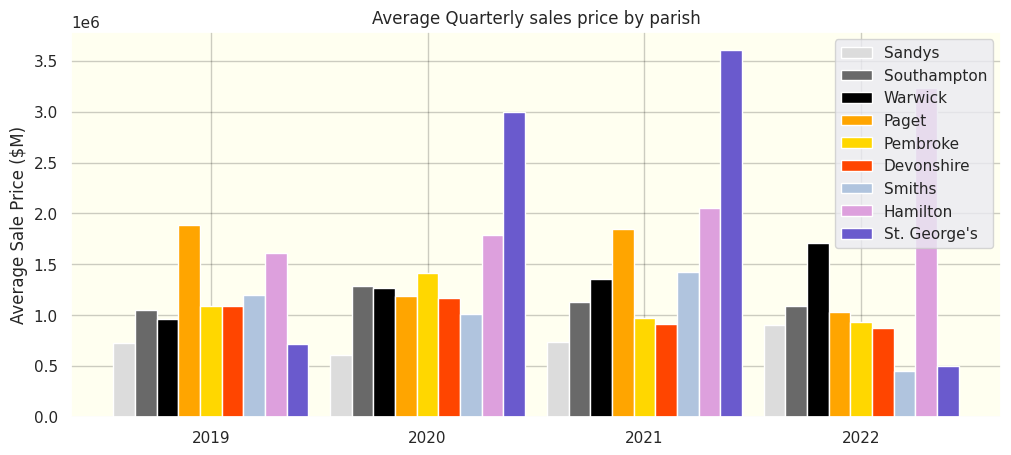

In [20]:
bar_graph_by_parish_and_period(df, "year")

# WARNING:

Some parishes will have missing quarterly data.  Therefore we will have to set that quarter to an average value of zero if we want it to be plotted.

### Graphs for (`by_parish`, `quarterly`) 

In [21]:
df = rep.import_sales_data("./../kw-data-import/data/kw-sales.csv") # import data
property_type = "house"
bracket = None
starting_year, final_year = 2019, 2022

period = "quarter"
location = "by_parish"
indicator = "average_sales_price"

df = rep.filter_property_type(df, property_type) # filter property type selected
df = rep.filter_by_bracket(df, house_price_brackets, bracket) # filter by market segment
df = rep.filter_year_interval(df, starting_year, final_year) # year interval
df = df.groupby(['parish','quarter'], as_index=False).agg({"price": "mean"})


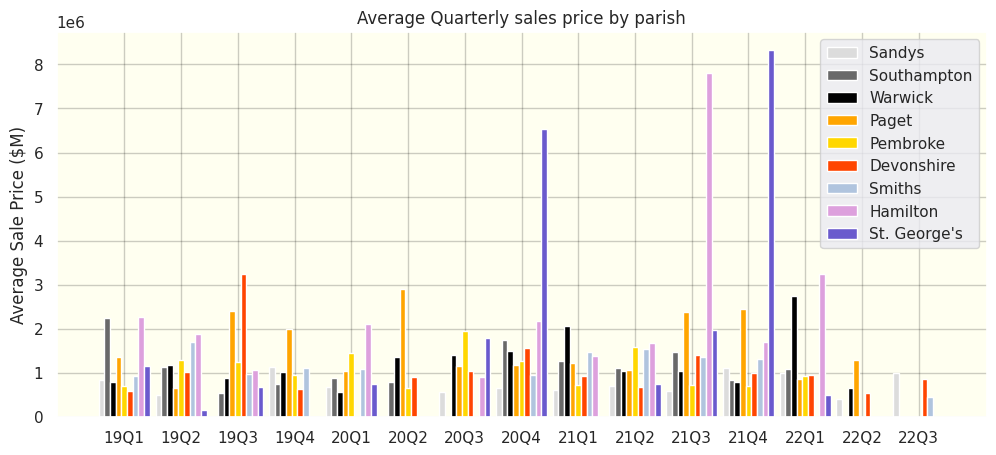

In [22]:
bar_graph_by_parish_and_period(df, "quarter")

# The above dataframe is the way to filter the criteria above: How to plot?

In [20]:
xx = df.groupby('parish', as_index=False).agg({"price": "max", 'year':'first', 'quarter':'first'})
xx["price"] = xx["price"].map(rep.smtm)
xx

,parish,price,year,quarter
0,City of Hamilton,"$15,000,000",2018,Q1
1,Devonshire,"$3,250,000",2018,Q1
2,Hamilton,"$7,800,000",2018,Q1
3,Paget,"$13,000,000",2018,Q1
4,Pembroke,"$6,500,000",2018,Q1
5,Sandys,"$3,000,000",2018,Q1
6,Smiths,"$4,200,000",2018,Q1
7,Southampton,"$4,900,000",2018,Q1
8,St. George's,"$11,000,000",2018,Q1
9,Town of St. George,"$1,250,000",2018,Q1


In [65]:
xx = df.groupby('parish', as_index=False).agg({"combined_arv": "median", 'year':'last', 'quarter':'first'})
xx["combined_arv"] = xx["combined_arv"].map(rep.smtm)
xx

,parish,combined_arv,year,quarter
0,City of Hamilton,"$36,000",2022,Q1
1,Devonshire,"$35,100",2022,Q1
2,Hamilton,"$31,200",2022,Q1
3,Paget,"$57,600",2022,Q1
4,Pembroke,"$37,200",2022,Q1
5,Sandys,"$29,400",2022,Q1
6,Smiths,"$61,800",2022,Q1
7,Southampton,"$27,000",2022,Q1
8,St. George's,"$34,200",2022,Q1
9,Town of St. George,"$24,600",2021,Q1


In [67]:
western = ['Sandys', 'Southampton', 'Warwick']
central = ['Paget', 'City of Hamilton', 'Pembroke']
eastern = ['Devonshire', 'Smiths', 'Hamilton',"St. George's","Town of St. George"]
        
parish_region_dictionary = {v:'western' for v in western}
parish_region_dictionary.update({v:'central' for v in central})
parish_region_dictionary.update({v:'eastern' for v in eastern})
        
p_by_pa = df.groupby('parish', as_index=False).agg({"price": "mean", 
                                                    'combined_arv':'mean', })
#                                                     'year':'first', 
#                                                     'quarter':'first'})

p_by_pa

,parish,price,combined_arv
0,City of Hamilton,9.944535e+05,70748.514851
1,Devonshire,8.357246e+05,39150.000000
2,Hamilton,1.018578e+06,39679.720280
3,Paget,1.337629e+06,63255.797101
4,Pembroke,9.490334e+05,48024.060150
5,Sandys,5.950727e+05,33041.379310
6,Smiths,1.375465e+06,80675.423729
7,Southampton,8.048078e+05,36428.906250
8,St. George's,1.788343e+06,56104.545455
9,Town of St. George,4.078611e+05,24900.000000


In [69]:
p_by_pa['price'].groupby(p_by_pa['parish'].map(parish_region_dictionary)).agg("count") # .agg("count") # .map(rep.smtm)

parish
central    3
eastern    4
western    3
Name: price, dtype: int64

In [121]:
df.groupby(["year"])["price"].agg("median").apply(rep.smtm)

year
2018    $795,000
2019    $750,000
2020    $614,250
2021    $797,500
2022    $857,500
Name: price, dtype: object

In [115]:
df.groupby(['year'])['price'].agg(["sum","mean","median", "max", "min"]).style.format('${0:,.0f}')


,sum,mean,median,max,min
year,,,,,
2018,"$67,842,125","$1,884,503","$1,877,500","$2,450,000","$1,506,625"
2019,"$38,950,255","$1,947,513","$1,897,500","$2,400,000","$1,540,000"
2020,"$25,210,000","$1,939,231","$1,900,000","$2,500,000","$1,575,000"
2021,"$30,493,000","$1,793,706","$1,698,000","$2,400,000","$1,525,000"
2022,"$8,181,750","$2,045,438","$2,103,375","$2,225,000","$1,750,000"


### Example 1: Yearly #of sales

In [4]:
yearly_price_stats = df.groupby(['year'])['price'].agg(["sum","mean","median", "max", "min"]).style.format('${0:,.0f}')
yearly_price_stats # ["sum"].apply(smtm)

,sum,mean,median,max,min
year,,,,,
2018,"$364,234,223","$1,061,907","$795,000","$10,500,000","$12,000"
2019,"$242,763,630","$974,954","$750,000","$15,000,000","$13,500"
2020,"$245,519,307","$909,331","$614,250","$11,000,000","$10,000"
2021,"$329,322,326","$1,210,744","$797,500","$13,000,000","$13,800"
2022,"$58,994,750","$1,229,057","$857,500","$4,725,000","$225,000"


In [5]:
yearly_nr_sales = df.groupby(['year'])['price'].agg(["count"]) # ,"mean","median", "max", "min"])
yearly_nr_sales['yr'] = yearly_nr_sales.index


In [ ]:
yearly_nr_sales = df.groupby(['year'])['price'].agg(["count"]) # ,"mean","median", "max", "min"])
yearly_nr_sales['yr'] = yearly_nr_sales.index

In [77]:
volume_quarterly_sales = df.resample(rule='BQ')['price'].agg("sum")
volume_quarterly_sales['yr'] = volume_quarterly_sales.index.year
# volume_quarterly_sales['q'] = volume_quarterly_sales.index.quarter.map(lambda x: 'Q'+str(x))

# volume_quarterly_sales["quarter"] = volume_quarterly_sales.index.quarter
# volume_quarterly_sales['quarter'] = volume_quarterly_sales['quarter'].map(lambda x : 'Q'+str(x))
# volume_quarterly_sales['yr'] = volume_quarterly_sales.date

In [79]:
volume_quarterly_sales.index # .quarter.map(lambda x: 'Q'+str(x))

Index([2018-03-30 00:00:00, 2018-06-29 00:00:00, 2018-09-28 00:00:00,
       2018-12-31 00:00:00, 2019-03-29 00:00:00, 2019-06-28 00:00:00,
       2019-09-30 00:00:00, 2019-12-31 00:00:00, 2020-03-31 00:00:00,
       2020-06-30 00:00:00, 2020-09-30 00:00:00, 2020-12-31 00:00:00,
       2021-03-31 00:00:00, 2021-06-30 00:00:00, 2021-09-30 00:00:00,
       2021-12-31 00:00:00, 2022-03-31 00:00:00, 2022-06-30 00:00:00,
       2022-09-30 00:00:00,                'yr'],
      dtype='object', name='date')

# NOTE

In the future, we may not have data for the last year (for example, it's March 2023, and we only have data until Feb. 2023).  Graphs that show yearly trends should indicate this.  See the function `rep.filter_indicator_and_period()` and `rep.create_bar_chart` for an example of how to implement this, and produce graphs like the following:

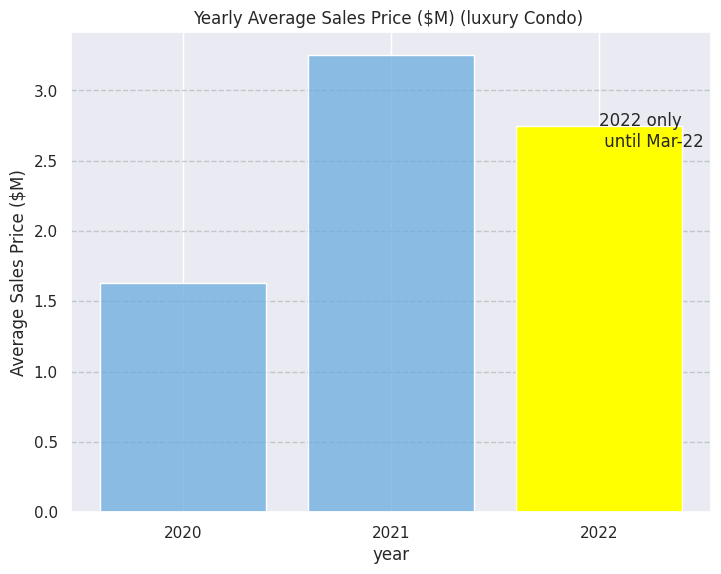